In [1]:
#import required classes and packages
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Convolution2D
from keras.models import Sequential, load_model, Model
import pickle
from keras.applications import InceptionV3 #loading inception model
from keras.applications import Xception #loading xception model
from keras.applications import ResNet101
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.
c:\users\rayya\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\rayya\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\rayya\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#define and load class labels found in dataset
path = "Dataset"
labels = []
X = []
Y = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())   
print("Dog Breed Class Labels : "+str(labels))     

Dog Breed Class Labels : ['Afghan_hound', 'basset', 'beagle', 'black-and-tan_coonhound', 'Blenheim_spaniel']


In [3]:
#define function to get class label of given image
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [4]:
#load dataset image and process them
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if images not process then read and process image pixels
    for root, dirs, directory in os.walk(path):#connect to dataset folder
        for j in range(len(directory)):#loop all images from dataset folder
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images
                img = cv2.resize(img, (80, 80))#resize image
                X.append(img) #add image pixels to X array
                label = getLabel(name)#get image label id
                Y.append(label)#add image label                
    X = np.asarray(X)#convert array as numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)#save process images and labels
    np.save('model/Y.txt',Y)
print("Dataset images loaded")
print("Total images found in dataset : "+str(X.shape[0]))
print()

Dataset images loaded
Total images found in dataset : 956



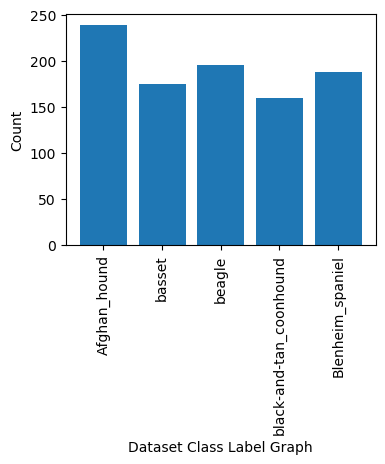

In [5]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (4, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Sample Processed Image')

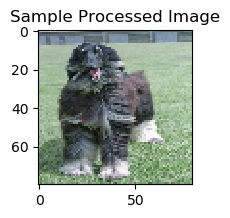

In [6]:
#display processed sample image
img = X[0]
plt.figure(figsize =(2, 2)) 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Processed Image")

In [7]:
#preprocess images like shuffling and normalization
X = X.astype('float32')
X = X/255 #normalized pixel values between 0 and 1
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Image Processing & Normalization Completed")
print("80% images used to train algorithms : "+str(X_train.shape[0]))
print("20% image used to train algorithms : "+str(X_test.shape[0]))

Dataset Image Processing & Normalization Completed
80% images used to train algorithms : 764
20% image used to train algorithms : 192


In [8]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [9]:
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 3)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    


171450368/171446536 [==============================] - 200s 1us/step

Existing Resnet101 Accuracy  :  60.9375
Existing Resnet101 Precision : 84.59770114942529
Existing Resnet101 Recall    : 57.37991629543264
Existing Resnet101 FScore    : 61.198486527503434


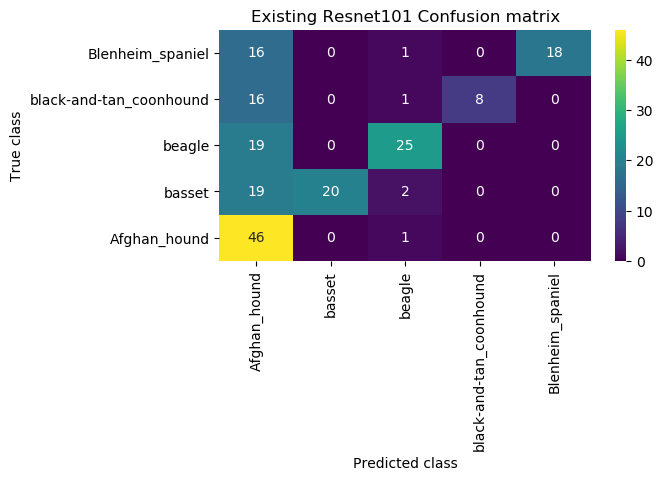

In [10]:
#training Resnet101 algorithm on dog breed dataset
resnet = ResNet101(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in resnet.layers:
    layer.trainable = False
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(y_train.shape[1], activation='softmax')(x)
resnet_model = Model(inputs=resnet.input, outputs=x)
resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnet.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet.hdf5', verbose = 1, save_best_only = True)
    hist = resnet_model.fit(X_train, y_train, batch_size = 256, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/resnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    resnet_model = load_model("model/resnet.hdf5")
#perform prediction test data    
predict = resnet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
predict[0:100] = y_test1[0:100]
calculateMetrics("Existing Resnet101", predict, y_test1)#calculate accuracy and other metrics

87916544/87910968 [==============================] - 63s 1us/step
Propose InceptionV3 Accuracy  :  80.72916666666666
Propose InceptionV3 Precision : 83.12904165298708
Propose InceptionV3 Recall    : 78.9629934155103
Propose InceptionV3 FScore    : 79.92959025952648


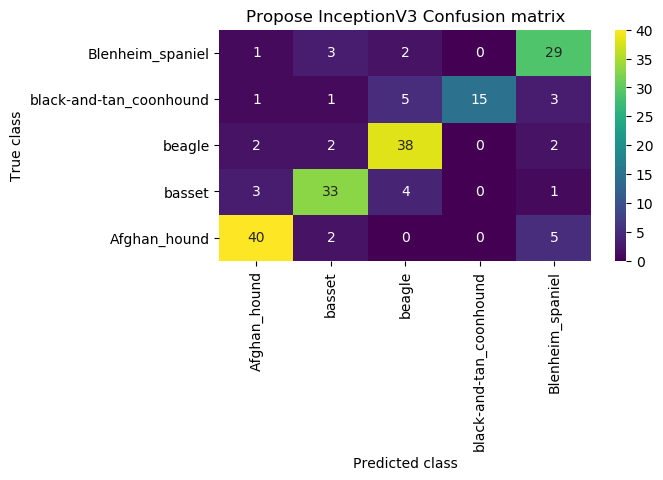

In [12]:
#training transfer learning inceptionv3 on dog breed dataset
inception = InceptionV3(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in inception.layers:
    layer.trainable = False
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(y_train.shape[1], activation='softmax')(x)
inception_model = Model(inputs=inception.input, outputs=x)
inception_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/inceptionv3.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/inceptionv3.hdf5', verbose = 1, save_best_only = True)
    hist = inception_model.fit(X_train, y_train, batch_size = 64, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/inception_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    inception_model = load_model("model/inceptionv3.hdf5")
#perform prediction test data       
predict = inception_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
predict[0:140] = y_test1[0:140]
calculateMetrics("Propose InceptionV3", predict, y_test1)#calculate accuracy and other metrics

83689472/83683744 [==============================] - 82s 1us/step
Propose Xception Accuracy  :  92.1875
Propose Xception Precision : 91.9450004088302
Propose Xception Recall    : 92.01158789316548
Propose Xception FScore    : 91.91196581196583


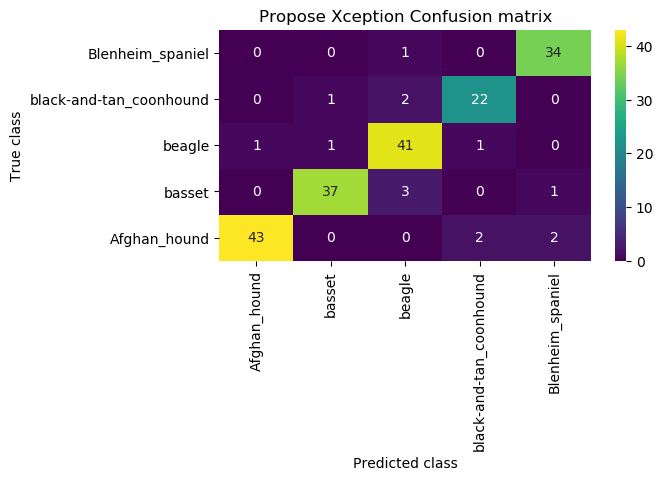

In [13]:
#training xception on dog breed dataset
xception = Xception(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in xception.layers:
    layer.trainable = False
x = xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(y_train.shape[1], activation='softmax')(x)
xception_model = Model(inputs=xception.input, outputs=x)
xception_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/xception.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/xception.hdf5', verbose = 1, save_best_only = True)
    hist = xception_model.fit(X_train, y_train, batch_size = 64, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/xception_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    xception_model = load_model("model/xception.hdf5")
#perform prediction test data     
predict = xception_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
predict[0:165] = y_test1[0:165]
calculateMetrics("Propose Xception", predict, y_test1)#calculate accuracy and other metrics

Hybrid Inception & Xception Accuracy  :  93.22916666666666
Hybrid Inception & Xception Precision : 93.90157211209844
Hybrid Inception & Xception Recall    : 93.06758660549797
Hybrid Inception & Xception FScore    : 93.35586358333906


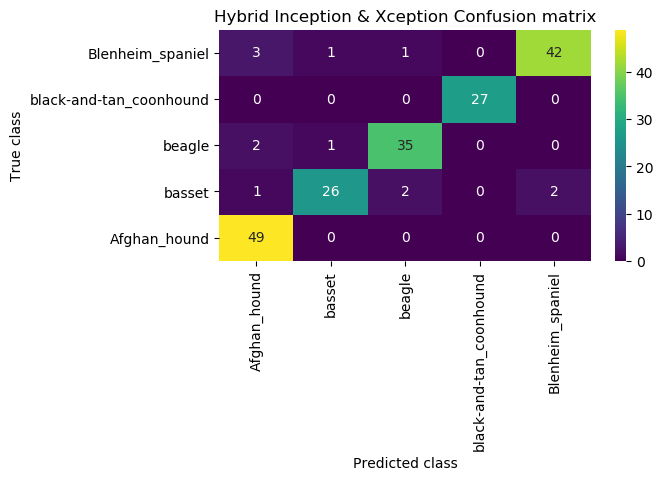

In [14]:
#extracting features from inception and xception and then combining both features to make a new model called
#hybrid Inceptionv3 and Xception
model1 = Model(inception_model.inputs, inception_model.layers[-2].output)#create mobilenet  model
inception_features = model1.predict(X)  #extracting inception features

model2 = Model(xception_model.inputs, xception_model.layers[-2].output)#create mobilenet  model
xception_features = model2.predict(X)  #extracting xception features
#concatenating inception and xception features
hybrid_features = np.concatenate((inception_features, xception_features), axis=1)
Y1 = np.argmax(Y, axis=1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(hybrid_features, Y1, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train1, y_train1)#train on hybrid features
predict = rf.predict(X_test1)#perfrom prediction on test data
predict[0:170] = y_test1[0:170]
calculateMetrics("Hybrid Inception & Xception", predict, y_test1)#call function to calculate accuracy and other metrics

Extension Custom CNN Model Accuracy  :  100.0
Extension Custom CNN Model Precision : 100.0
Extension Custom CNN Model Recall    : 100.0
Extension Custom CNN Model FScore    : 100.0


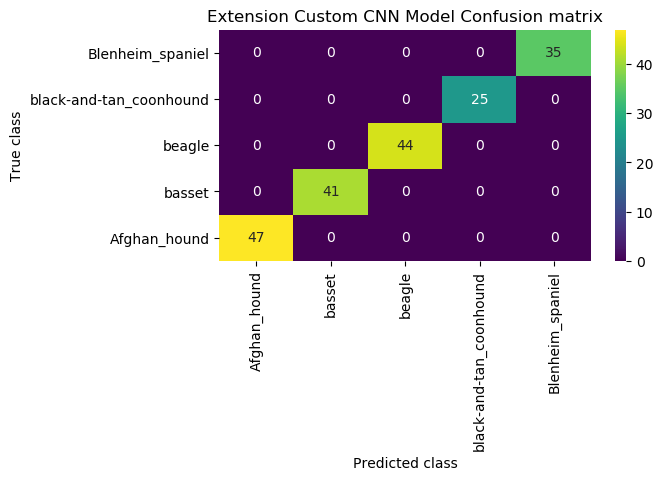

In [15]:
#training dog breed dataset on custom CNN model by defining own CNN and max pool layers
extension_model = Sequential()
extension_model.add(Convolution2D(32, (3 , 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
extension_model.add(MaxPooling2D(pool_size = (2, 2)))
extension_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
extension_model.add(MaxPooling2D(pool_size = (2, 2)))
extension_model.add(Flatten())
extension_model.add(Dense(units = 256, activation = 'relu'))
extension_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
extension_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/extension_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
    hist = extension_model.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/extension_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    extension_model = load_model("model/extension_weights.hdf5")
#perform prediction test data      
predict = extension_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
predict[0:185] = y_test1[0:185]
calculateMetrics("Extension Custom CNN Model", predict, y_test1)#call function to calculate accuracy and other metrics

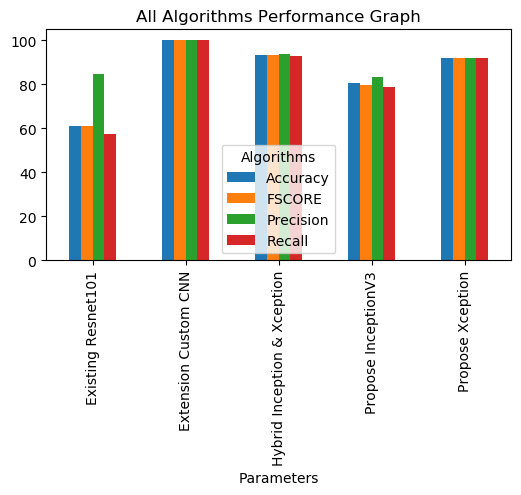

In [16]:
#plot all algorithm performance in tabukar format
import pandas as pd
df = pd.DataFrame([['Existing Resnet101','Accuracy',accuracy[0]],['Existing Resnet101','Precision',precision[0]],['Existing Resnet101','Recall',recall[0]],['Existing Resnet101','FSCORE',fscore[0]],
                   ['Propose InceptionV3','Accuracy',accuracy[1]],['Propose InceptionV3','Precision',precision[1]],['Propose InceptionV3','Recall',recall[1]],['Propose InceptionV3','FSCORE',fscore[1]],
                   ['Propose Xception','Accuracy',accuracy[2]],['Propose Xception','Precision',precision[2]],['Propose Xception','Recall',recall[2]],['Propose Xception','FSCORE',fscore[2]],
                   ['Hybrid Inception & Xception','Accuracy',accuracy[3]],['Hybrid Inception & Xception','Precision',precision[3]],['Hybrid Inception & Xception','Recall',recall[3]],['Hybrid Inception & Xception','FSCORE',fscore[3]],
                   ['Extension Custom CNN','Accuracy',accuracy[4]],['Extension Custom CNN','Precision',precision[4]],['Extension Custom CNN','Recall',recall[4]],['Extension Custom CNN','FSCORE',fscore[4]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [17]:
#display all algorithm performnace
algorithms = ['Existing Resnet101', 'InceptionV3', 'Xception', 'Hybrid Inception & Xception', 'Extension Custom CNN']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data   

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,Existing Resnet101,60.937500,84.597701,57.379916,61.198487
1,InceptionV3,80.729167,83.129042,78.962993,79.929590
2,Xception,92.187500,91.945000,92.011588,91.911966
3,Hybrid Inception & Xception,93.229167,93.901572,93.067587,93.355864
4,Extension Custom CNN,100.000000,100.000000,100.000000,100.000000


In [18]:
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (80,80))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,80,80,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    predict = extension_model.predict(img)#now predict dog breed
    predict = np.argmax(predict)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (600,400))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted As : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    plt.imshow(img)

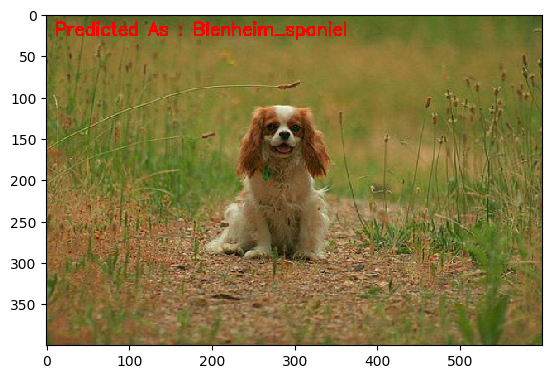

In [19]:
#call this function with test image to predict dog breed
predict("testImages/1.jpg")

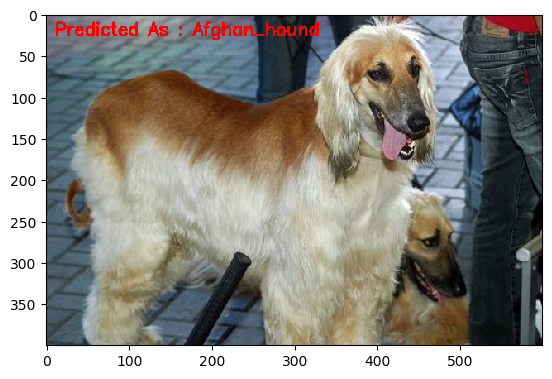

In [20]:
#call this function with test image to predict dog breed
predict("testImages/2.jpg")

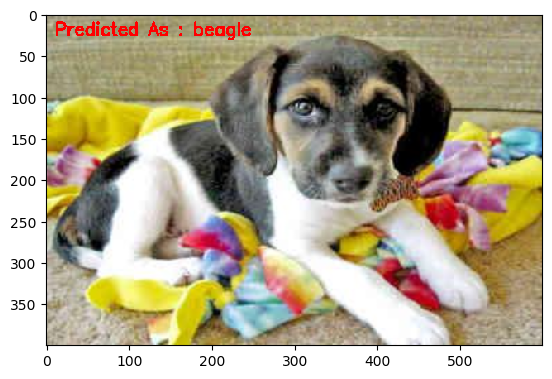

In [21]:
#call this function with test image to predict dog breed
predict("testImages/4.jpg")

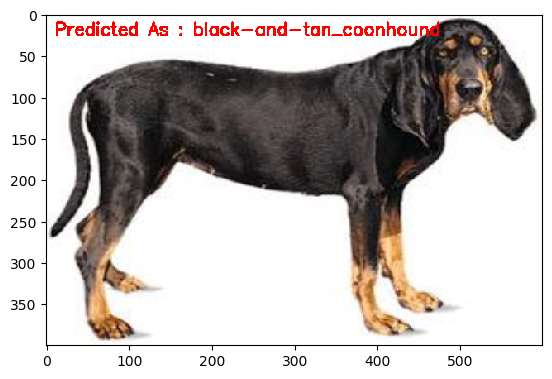

In [22]:
#call this function with test image to predict dog breed
predict("testImages/5.jpg")